Note: sesuaikan semua `/path/to/` menuju directory yang sesuai

# Installs

In [ ]:
!pip install -U tensorflow scikit-learn nervaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 5.2 kB/s 
     |████████████████████████████████| 438 kB 67.5 MB/s 
     |████████████████████████████████| 1.6 MB 40.8 MB/s 
     |████████████████████████████████| 5.8 MB 31.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

# Imports

In [ ]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib

from gensim import models

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras import Sequential, Model
from keras.layers import TimeDistributed, Dense, LSTM, Bidirectional, Embedding, Input, Lambda, Reshape, RepeatVector
import keras.backend as K
from keras.models import load_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13113422892516879257
xla_global_id: -1
]
Default GPU Device: 


# Load Data

In [ ]:
df_atis_test = pd.read_csv('https://raw.githubusercontent.com/moore3930/SlotRefine/main/data/atis/test/data', header=None, sep="\t", names=["data", "encoding", "ground_truth"])
df_atis_train = pd.read_csv('https://raw.githubusercontent.com/moore3930/SlotRefine/main/data/atis/train/data', header=None, sep="\t", names=["data", "encoding", "ground_truth"])
df_atis_val = pd.read_csv('https://raw.githubusercontent.com/moore3930/SlotRefine/main/data/atis/valid/data', header=None, sep="\t", names=["data", "encoding", "ground_truth"])

In [ ]:
df_atis_concat = pd.concat([df_atis_train, df_atis_test, df_atis_val]).reset_index()

In [ ]:
from functools import reduce
TAGS = np.unique(list(reduce(lambda x,y:x+y, map(lambda x:x.split(), df_atis_concat.encoding))))

In [ ]:
TAGS

array(['B-aircraft_code', 'B-airline_code', 'B-airline_name',
       'B-airport_code', 'B-airport_name', 'B-arrive_date.date_relative',
       'B-arrive_date.day_name', 'B-arrive_date.day_number',
       'B-arrive_date.month_name', 'B-arrive_date.today_relative',
       'B-arrive_time.end_time', 'B-arrive_time.period_mod',
       'B-arrive_time.period_of_day', 'B-arrive_time.start_time',
       'B-arrive_time.time', 'B-arrive_time.time_relative',
       'B-booking_class', 'B-city_name', 'B-class_type', 'B-compartment',
       'B-connect', 'B-cost_relative', 'B-day_name', 'B-day_number',
       'B-days_code', 'B-depart_date.date_relative',
       'B-depart_date.day_name', 'B-depart_date.day_number',
       'B-depart_date.month_name', 'B-depart_date.today_relative',
       'B-depart_date.year', 'B-depart_time.end_time',
       'B-depart_time.period_mod', 'B-depart_time.period_of_day',
       'B-depart_time.start_time', 'B-depart_time.time',
       'B-depart_time.time_relative', 'B-econom

In [ ]:
NUM_TAGS = len(TAGS)
NUM_TAGS

127

In [ ]:
df_atis_concat.head()["data"][0]

'i want to fly from baltimore to dallas round trip'

In [ ]:
df_atis_concat.head()

index                                               data  \
0      0  i want to fly from baltimore to dallas round trip   
1      1  round trip fares from baltimore to philadelphi...   
2      2  show me the flights arriving on baltimore on j...   
3      3  what are the flights which depart from san fra...   
4      4  which airlines fly from boston to washington d...   

                                            encoding  ground_truth  
0  O O O O O B-fromloc.city_name O B-toloc.city_n...   atis_flight  
1  B-round_trip I-round_trip O O B-fromloc.city_n...  atis_airfare  
2  O O O O O O B-toloc.city_name O B-arrive_date....   atis_flight  
3  O O O O O O O B-fromloc.city_name I-fromloc.ci...   atis_flight  
4  O O O O B-fromloc.city_name O B-toloc.city_nam...  atis_airline

In [ ]:
len(sorted(df_atis_concat.data, key=lambda x:len(x.split(" ")))[-1])

259

In [ ]:
np.unique(df_atis_train.ground_truth)

array(['atis_abbreviation', 'atis_aircraft',
       'atis_aircraft#atis_flight#atis_flight_no', 'atis_airfare',
       'atis_airline', 'atis_airline#atis_flight_no', 'atis_airport',
       'atis_capacity', 'atis_cheapest', 'atis_city', 'atis_distance',
       'atis_flight', 'atis_flight#atis_airfare', 'atis_flight_no',
       'atis_flight_time', 'atis_ground_fare', 'atis_ground_service',
       'atis_ground_service#atis_ground_fare', 'atis_meal',
       'atis_quantity', 'atis_restriction'], dtype=object)

Uncomment this if using Google Colab and Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Model Word2Vec LSTM

## Word2Vec dan Data Preprocessing

Link model word2vec: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g

In [ ]:
word2vec = models.KeyedVectors.load_word2vec_format(
    '/path/to/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
# refer to https://towardsdatascience.com/pos-tagging-using-rnn-7f08a522f849
# and https://www.kaggle.com/code/tanyadayanand/pos-tagging-using-rnn/notebook

def tokenize(seqs, oov_token=None):
  tokenizer = Tokenizer(oov_token=oov_token, split=" ", filters='')
  tokenizer.fit_on_texts(seqs)
  return tokenizer, tokenizer.texts_to_sequences(seqs)

In [ ]:
word_tokenizer, X_train_encoded = tokenize(df_atis_train.data)
tag_tokenizer, Y_train_encoded = tokenize(df_atis_train.encoding, oov_token="o")

In [ ]:
NUM_CLASSES = len(tag_tokenizer.word_index) + 2

In [ ]:
X_test_encoded = word_tokenizer.texts_to_sequences(df_atis_test.data)
Y_test_encoded = tag_tokenizer.texts_to_sequences(df_atis_test.encoding)
X_val_encoded = word_tokenizer.texts_to_sequences(df_atis_val.data)
Y_val_encoded = tag_tokenizer.texts_to_sequences(df_atis_val.encoding)

In [ ]:
MAX_SEQ_LENGTH = 256

X_train_padded = pad_sequences(X_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_train_padded = pad_sequences(Y_train_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
X_test_padded = pad_sequences(X_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_test_padded = pad_sequences(Y_test_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
X_val_padded = pad_sequences(X_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_val_padded = pad_sequences(Y_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_train_categorical = to_categorical(Y_train_padded, num_classes=NUM_CLASSES)
Y_test_categorical = to_categorical(Y_test_padded, num_classes=NUM_CLASSES)
Y_val_categorical = to_categorical(Y_val_padded, num_classes=NUM_CLASSES)

In [ ]:
intent_encoder = LabelBinarizer().fit(df_atis_train.ground_truth)
Y_train_intent = intent_encoder.transform(df_atis_train.ground_truth)
Y_test_intent = intent_encoder.transform(df_atis_test.ground_truth)
Y_val_intent = intent_encoder.transform(df_atis_val.ground_truth)

In [ ]:
INTENT_CLASSES = len(np.unique(df_atis_train.ground_truth))

In [ ]:
EMBEDDING_SIZE  = 300  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

In [ ]:
# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [ ]:
Y_val_categorical.shape

(500, 256, 122)

In [ ]:
len(tag_tokenizer.word_index)

120

## Membuat Kerangka Model

In [ ]:
EMBEDDING_SIZE = 300
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

w2v_model = Sequential()

In [ ]:
w2v_model.add(Input(shape=(MAX_SEQ_LENGTH,)))

# vocabulary size — number of unique words in data
# length of vector with which each word is represented
w2v_model.add(Embedding(input_dim = VOCABULARY_SIZE, 
  output_dim = EMBEDDING_SIZE, 
# length of input sequence
  input_length = MAX_SEQ_LENGTH, 
# word embedding matrix
  weights = [embedding_weights],
# True — update embeddings_weight matrix
  trainable = False 
))

In [ ]:
w2v_model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(EMBEDDING_SIZE,1)))
w2v_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
w2v_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

w2v_model.build(input_shape=(EMBEDDING_SIZE, 1))
w2v_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 300)          260400    
                                                                 
 bidirectional (Bidirectiona  (None, 256, 256)         439296    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 256, 122)         31354     
 ibuted)                                                         
                                                                 
Total params: 731,050
Trainable params: 470,650
Non-trainable params: 260,400
_________________________________________________________________


## Training model Argument/POS

In [ ]:
Y_train_categorical[-1].shape

(256, 122)

In [ ]:
X_train_padded[-1].shape

(256,)

In [ ]:
history = w2v_model.fit(X_train_padded, Y_train_categorical, batch_size=256, epochs=20, validation_data=(X_val_padded, Y_val_categorical))

Epoch 1/20
18/18 [==============================] - 83s 4s/step - loss: 2.6306 - categorical_accuracy: 0.9483 - val_loss: 0.2651 - val_categorical_accuracy: 0.9554
Epoch 2/20
18/18 [==============================] - 77s 4s/step - loss: 0.1704 - categorical_accuracy: 0.9640 - val_loss: 0.1154 - val_categorical_accuracy: 0.9791
Epoch 3/20
18/18 [==============================] - 77s 4s/step - loss: 0.0944 - categorical_accuracy: 0.9817 - val_loss: 0.0872 - val_categorical_accuracy: 0.9834
Epoch 4/20
18/18 [==============================] - 78s 4s/step - loss: 0.0789 - categorical_accuracy: 0.9853 - val_loss: 0.0780 - val_categorical_accuracy: 0.9852
Epoch 5/20
18/18 [==============================] - 76s 4s/step - loss: 0.0714 - categorical_accuracy: 0.9870 - val_loss: 0.0722 - val_categorical_accuracy: 0.9868
Epoch 6/20
18/18 [==============================] - 77s 4s/step - loss: 0.0660 - categorical_accuracy: 0.9881 - val_loss: 0.0673 - val_categorical_accuracy: 0.9875
Epoch 7/20
18/18

In [ ]:
w2v_model.add(Lambda(lambda x: K.argmax(x)))

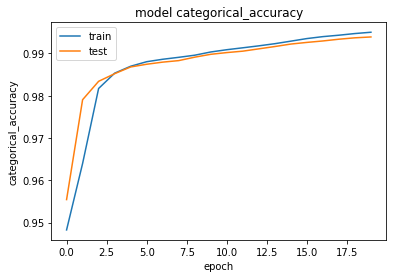

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model categorical_accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

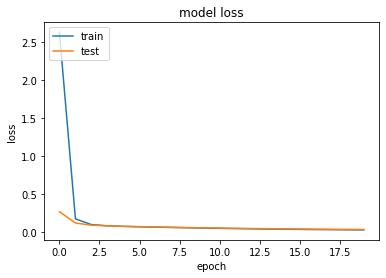

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = w2v_model.predict(X_test_padded)

28/28 [==============================] - 11s 365ms/step


In [ ]:
y_pred_dec = list(map(lambda x: tag_tokenizer.sequences_to_texts([x[0][-len(x[1]):]])[0],
                      zip(y_pred, Y_test_encoded)))

In [ ]:
Y_test_encoded[:5]

[[2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 5, 2, 2, 2, 2, 2, 20, 52],
 [2, 12, 11, 2, 2, 2, 2, 2, 4, 2, 3, 5, 2, 18, 13, 19],
 [2, 12, 11, 2, 2, 2, 2, 2, 2, 4, 2, 3, 5],
 [2, 2, 2, 2, 2, 2, 14, 15, 2, 4, 2, 3, 5, 2, 12, 11],
 [2, 2, 2, 2, 2, 2, 4, 2, 3, 5, 5, 2, 12, 11, 2, 7, 10]]

In [ ]:
tag_tokenizer.sequences_to_texts(Y_test_encoded)[:5]

['o o o o o o o o b-fromloc.city_name o b-toloc.city_name i-toloc.city_name o o o o o b-stoploc.city_name i-stoploc.city_name',
 'o b-depart_date.month_name b-depart_date.day_number o o o o o b-fromloc.city_name o b-toloc.city_name i-toloc.city_name o b-depart_time.time_relative b-depart_time.time i-depart_time.time',
 'o b-depart_date.month_name b-depart_date.day_number o o o o o o b-fromloc.city_name o b-toloc.city_name i-toloc.city_name',
 'o o o o o o b-round_trip i-round_trip o b-fromloc.city_name o b-toloc.city_name i-toloc.city_name o b-depart_date.month_name b-depart_date.day_number',
 'o o o o o o b-fromloc.city_name o b-toloc.city_name i-toloc.city_name i-toloc.city_name o b-depart_date.month_name b-depart_date.day_number o b-airline_name i-airline_name']

In [ ]:
y_pred_dec[:5]

['o o o o o o o o b-fromloc.city_name o b-toloc.city_name i-toloc.city_name o o o o o o b-toloc.city_name',
 'o b-depart_date.month_name o o o o o o b-fromloc.city_name o b-toloc.city_name i-toloc.city_name o b-depart_time.time_relative b-depart_time.time i-depart_time.time',
 'o b-depart_date.month_name o o o o o o o b-fromloc.city_name o b-toloc.city_name i-toloc.city_name',
 'o o o o o o o o o b-fromloc.city_name o b-toloc.city_name i-toloc.city_name o b-depart_date.month_name b-depart_date.day_number',
 'o o o o o o b-fromloc.city_name o o i-toloc.city_name i-toloc.city_name o b-depart_date.month_name b-depart_date.day_number o b-airline_name i-airline_name']

## Intent Detection

In [ ]:
intent_model = Sequential(w2v_model)
intent_model.layers[0].trainable = False
intent_model.add(Lambda(lambda x:tf.cast(x, tf.float32)))
intent_model.add(Reshape((MAX_SEQ_LENGTH, 1)))
intent_model.add(Bidirectional(LSTM(200), input_shape=(MAX_SEQ_LENGTH, 1)))
intent_model.add(Dense(INTENT_CLASSES, activation='softmax'))

In [ ]:
intent_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256)               731050    
                                                                 
 lambda_4 (Lambda)           (None, 256)               0         
                                                                 
 reshape_3 (Reshape)         (None, 256, 1)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 400)              323200    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 21)                8421      
                                                                 
Total params: 1,062,671
Trainable params: 331,621
Non-trainable params: 731,050
________________________________________

In [ ]:
intent_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [ ]:
history_intent = intent_model.fit(X_train_padded, Y_train_intent, batch_size=256, epochs=20, validation_data=(X_val_padded, Y_val_intent))

Epoch 1/20
18/18 [==============================] - 136s 7s/step - loss: 1.6700 - categorical_accuracy: 0.6981 - val_loss: 1.2519 - val_categorical_accuracy: 0.7140
Epoch 2/20
18/18 [==============================] - 134s 7s/step - loss: 1.0964 - categorical_accuracy: 0.7389 - val_loss: 1.1743 - val_categorical_accuracy: 0.7140
Epoch 3/20
18/18 [==============================] - 114s 6s/step - loss: 1.0494 - categorical_accuracy: 0.7389 - val_loss: 1.1322 - val_categorical_accuracy: 0.7140
Epoch 4/20
18/18 [==============================] - 120s 7s/step - loss: 1.0090 - categorical_accuracy: 0.7394 - val_loss: 1.1029 - val_categorical_accuracy: 0.7180
Epoch 5/20
18/18 [==============================] - 106s 6s/step - loss: 0.9735 - categorical_accuracy: 0.7450 - val_loss: 1.0650 - val_categorical_accuracy: 0.7120
Epoch 6/20
18/18 [==============================] - 104s 6s/step - loss: 0.9585 - categorical_accuracy: 0.7523 - val_loss: 1.0497 - val_categorical_accuracy: 0.7160
Epoch 7/20

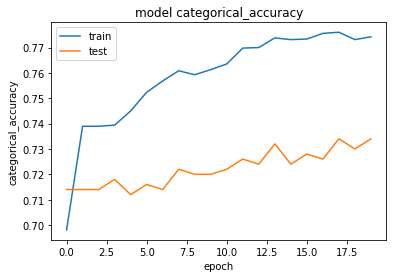

In [ ]:
plt.plot(history_intent.history['categorical_accuracy'])
plt.plot(history_intent.history['val_categorical_accuracy'])
plt.title('model categorical_accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

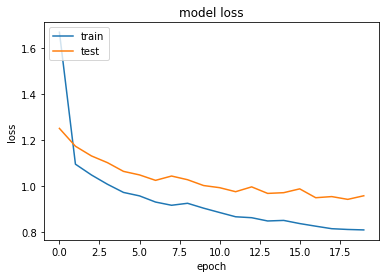

In [ ]:
plt.plot(history_intent.history['loss'])
plt.plot(history_intent.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred_intent = intent_model.predict(X_test_padded)

28/28 [==============================] - 20s 643ms/step


In [ ]:
y_pred_intent[:5]

array([[3.46588960e-04, 2.30116304e-02, 6.66296924e-04, 1.66752115e-02,
        1.64627694e-02, 5.25266980e-04, 3.05295252e-04, 8.51253571e-04,
        1.30215325e-04, 1.46497146e-03, 2.64645391e-03, 8.93610299e-01,
        7.71420123e-03, 6.69307401e-03, 1.10354181e-02, 2.88676121e-04,
        1.34940641e-02, 5.34200633e-04, 1.41376664e-03, 1.04169128e-03,
        1.08857674e-03],
       [5.80476672e-06, 3.72611941e-03, 7.09491405e-06, 1.18288510e-02,
        4.49147308e-03, 1.20811783e-05, 1.79936251e-05, 3.31422743e-05,
        7.86620240e-06, 4.52567037e-04, 2.63558148e-04, 9.72833872e-01,
        2.90793978e-04, 6.92537171e-04, 2.26242212e-03, 3.80051970e-05,
        3.53373325e-04, 6.87009833e-06, 6.83616890e-05, 2.56924634e-03,
        3.81233949e-05],
       [1.19822340e-04, 3.25336494e-03, 6.85614286e-05, 9.96369049e-02,
        5.85170798e-02, 1.04798244e-04, 2.82028515e-04, 3.29814357e-04,
        8.45800678e-05, 6.39762264e-04, 3.59110162e-03, 7.99856186e-01,
        1.5648

In [ ]:
df_atis_test.ground_truth[:5]

0     atis_flight
1    atis_airfare
2     atis_flight
3     atis_flight
4     atis_flight
Name: ground_truth, dtype: object

In [ ]:
y_pred_intent_dec = intent_encoder.inverse_transform(y_pred_intent)

In [ ]:
y_pred_intent_dec[:5]

array(['atis_flight', 'atis_flight', 'atis_flight', 'atis_flight',
       'atis_flight'], dtype='<U40')

## Menyimpan Model

In [ ]:
w2v_model.save('/path/to/LSTM/ATIS/Tag/')
intent_model.save('/path/to/LSTM/ATIS/Intent/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Manusia Learning/LSTM/ATIS/Tag/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Manusia Learning/LSTM/ATIS/Tag/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Manusia Learning/LSTM/ATIS/Intent/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Manusia Learning/LSTM/ATIS/Intent/assets


Sumber: https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring

In [ ]:
# saving word_tokenizer
with open('/path/to/LSTM/ATIS/word_tokenizer_w2vLSTM.pickle', 'wb') as handle:
    pickle.dump(word_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving tag_tokenizer
with open('/path/to/LSTM/ATIS/tag_tokenizer_w2vLSTM.pickle', 'wb') as handle:
    pickle.dump(tag_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving intent encoder
with open('/path/to/LSTM/ATIS/intent_encoder_w2vLSTM.pickle', 'wb') as handle:
    pickle.dump(intent_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Load model

Sebelum menjalankan ini, jalankan dahulu bagian `Installs` dan `Imports`

Sesuaikan path di bawah ini dengan path menuju folder yang sesuai. Silakan merujuk pada link https://drive.google.com/drive/folders/105ETAA9leXX3tQfJ1pWKGJgV_uf0R91j?usp=sharing untuk struktur folder.

In [ ]:
with open('/path/to/LSTM/ATIS/word_tokenizer_w2vLSTM.pickle', 'rb') as handle:
  word_tokenizer_load = pickle.load(handle)

In [ ]:
with open('/path/to/LSTM/ATIS/tag_tokenizer_w2vLSTM.pickle', 'rb') as handle:
  tag_tokenizer_load = pickle.load(handle)

In [ ]:
with open('/path/to/LSTM/ATIS/intent_encoder_w2vLSTM.pickle', 'rb') as handle:
  intent_encoder_load = pickle.load(handle)

In [ ]:
load_w2v_model = load_model("/path/to/LSTM/ATIS/Tag")
load_intent_model = load_model("/path/to/LSTM/ATIS/Intent")

In [ ]:
with open('/path/to/LSTM/ATIS/intent_encoder_w2vLSTM.pickle', 'rb') as handle:
  intent_encoder_load = pickle.load(handle)

In [ ]:
def get_args(w2v_pred_dec, string):
  curr_phrase_tag = ''
  args = []
  for tag, token in zip(w2v_pred_dec.split(" "), string.split(" ")):
    if tag == 'o':
      curr_phrase_tag = ''
      continue
    elif not tag.startswith(('b-', 'i-')):
      args.append([tag, token])
      curr_phrase_tag = ''
    elif tag.startswith('b-'):
      curr_phrase_tag = tag[2:]
      args.append([curr_phrase_tag, token])
    else:
      if tag[2:] == curr_phrase_tag:
        args[-1][1] += f" {token}"
  return args

In [ ]:
def nlu(string, word_tokenizer, tag_tokenizer, w2v_model, intent_model, intent_encoder, max_seq_length = 256):
  str_enc = word_tokenizer.texts_to_sequences([string])
  str_pad = pad_sequences(str_enc, maxlen=max_seq_length, padding="pre", truncating="post")
  w2v_pred = w2v_model.predict(str_pad)
  intent_pred = intent_model.predict(str_pad)
  w2v_pred_dec = list(map(lambda x: tag_tokenizer.sequences_to_texts([x[0][-len(x[1]):]])[0],
                      zip(w2v_pred, [string.split(" ")])))
  intent_pred_dec = intent_encoder.inverse_transform(intent_pred)
  return {'args': get_args(w2v_pred_dec[0], string), 'intent': intent_pred_dec[0]}

In [ ]:
nlu('i need a flight from washington dc to san diego', word_tokenizer_load, tag_tokenizer_load, load_w2v_model, load_intent_model, intent_encoder_load)

1/1 [==============================] - 0s 340ms/step


{'args': [['fromloc.city_name', 'washington'],
  ['fromloc.city_name', 'dc'],
  ['toloc.city_name', 'san diego']],
 'intent': 'atis_flight'}

# Evaluasi

## F1 Score Model Word2Vec LSTM

In [ ]:
from functools import reduce
tags = np.unique(list(map(lambda x:x[2:], filter(lambda x:x!="O", reduce(lambda x, y: x+y.split(" "), df_atis_test.encoding, [])))))

In [ ]:
from nervaluate import Evaluator

res, res_type = Evaluator(list(map(lambda x:x.split(" "), tag_tokenizer.sequences_to_texts(Y_test_encoded))), list(map(lambda x:x.split(" "), y_pred_dec)), tags=tags, loader="list").evaluate()

In [ ]:
pd.DataFrame(res)

ent_type      partial       strict        exact
correct    2061.000000  2038.000000  1840.000000  2038.000000
incorrect   294.000000     0.000000   515.000000   317.000000
partial       0.000000   317.000000     0.000000     0.000000
missed      467.000000   467.000000   467.000000   467.000000
spurious     85.000000    85.000000    85.000000    85.000000
possible   2822.000000  2822.000000  2822.000000  2822.000000
actual     2440.000000  2440.000000  2440.000000  2440.000000
precision     0.844672     0.900205     0.754098     0.835246
recall        0.730333     0.778349     0.652020     0.722183
f1            0.783352     0.834854     0.699354     0.774610

## Intent Detection

In [ ]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(df_atis_test.ground_truth, y_pred_intent_dec, output_dict=True, zero_division=0)).transpose()

precision    recall  f1-score     support
atis_abbreviation             0.348837  0.454545  0.394737   33.000000
atis_aircraft                 0.000000  0.000000  0.000000    9.000000
atis_airfare                  0.400000  0.250000  0.307692   48.000000
atis_airfare#atis_flight      0.000000  0.000000  0.000000    1.000000
atis_airline                  0.000000  0.000000  0.000000   38.000000
atis_airport                  0.000000  0.000000  0.000000   18.000000
atis_capacity                 0.000000  0.000000  0.000000   21.000000
atis_city                     0.000000  0.000000  0.000000    6.000000
atis_day_name                 0.000000  0.000000  0.000000    2.000000
atis_distance                 0.000000  0.000000  0.000000   10.000000
atis_flight                   0.772727  0.968354  0.859551  632.000000
atis_flight#atis_airfare      0.000000  0.000000  0.000000   12.000000
atis_flight#atis_airline      0.000000  0.000000  0.000000    1.000000
atis_flight_no                0.000000  0.000000  0.000000    8.000000
atis_flight_no#atis_airline   0.000000  0.000000  0.000000    1.000000
atis_flight_time              0.000000  0.000000  0.000000    1.000000
atis_ground_fare              0.000000  0.000000  0.000000    7.000000
atis_ground_service           0.571429  0.444444  0.500000   36.000000
atis_meal                     0.000000  0.000000  0.000000    6.000000
atis_quantity                 0.000000  0.000000  0.000000    3.000000
accuracy                      0.733483  0.733483  0.733483    0.733483
macro avg                     0.104650  0.105867  0.103099  893.000000
weighted avg                  0.604308  0.733483  0.659610  893.000000